In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [55]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [56]:
from tensorflow.keras import layers

from bert.dataset import create_masked_input_dataset
from bert.layers import (PositionEmbedding, Attention, Transformer, TokenEmbedding, Bias,
                         gelu, masked_sparse_categorical_crossentropy, ECE, InverseSquareRootSchedule,
                         initializer, Projection)

In [57]:
vocab_size = 22
max_seq_len = 1024
batchSize = 10

def encode(line_tensor):
    line = line_tensor.numpy().decode('utf8')

    if len(line) > max_seq_len:
        offset = np.random.randint(
            low=0, high=len(line) - max_seq_len + 1)
        line = line[offset:(offset + max_seq_len)]

    vocab = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K',
             'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 
             'W', 'Y']

    replacement_dict = {key: i + 2 for i, key in enumerate(vocab)}
    return np.asarray([replacement_dict[item] for item in line])

def encode_tf(line_tensor):
    return tf.py_function(encode, inp=[line_tensor], Tout=[tf.int32,])

training_data = create_masked_input_dataset(
    encode_fn=encode_tf,
    sequence_path='/projects/bpms/pstjohn/uniparc/sequences_train.txt',
    max_sequence_length=max_seq_len,
    batch_size=batchSize,
    buffer_size=1024,
    vocab_size=vocab_size,
    mask_index=1,
    vocab_start=2,
    fix_sequence_length=True)

training_data.repeat().prefetch(tf.data.experimental.AUTOTUNE)

valid_data = create_masked_input_dataset(
    encode_fn=encode_tf,
    sequence_path='/projects/bpms/pstjohn/uniparc/sequences_valid.txt',
    max_sequence_length=max_seq_len,
    batch_size=batchSize,
    buffer_size=1024,
    vocab_size=vocab_size,
    mask_index=1,
    vocab_start=2,
    fix_sequence_length=True)

valid_data.repeat().prefetch(tf.data.experimental.AUTOTUNE)

<PrefetchDataset shapes: ((None, 1024), (None, 1024)), types: (tf.int32, tf.int32)>

In [58]:
masked_seqs, true_values = next(iter(valid_data))

In [59]:
masked_seqs[true_values != 0]

<tf.Tensor: id=3358440, shape=(533,), dtype=int32, numpy=
array([ 1,  1,  1,  1,  1,  1,  1,  1, 19,  1,  1, 17,  1,  1,  1, 10,  1,
       16, 16,  1,  1,  7,  1,  1,  1,  1,  1,  1,  2,  8, 15,  3,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 14,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, 11,  1,  1,  7,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  5,  1,  1,  1,  1, 14,  1,  1,  1,
        1,  1,  1, 11,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 10,  1,
        1,  1,  8,  1, 20,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, 16,  5,  1,  1, 12,  1,  1,  1,  1,  2,  1,  1,  1,  1,
       17,  1,  1,  1,  1, 17,  1,  1,  1,  1,  1,  1,  1,  1,  1,  4,  1,
        1,  9,  1,  1,  1,  1,  2, 18,  1,  1,  1,  1,  1,  1,  7,  1, 16,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  4,  1, 10, 13,  1,
        9,  1,  1,  1,  1,  1,  1,  2,  1,

In [60]:
true_values.shape

TensorShape([10, 1024])

## BERT layers

In [69]:
embedding_dimension = 128
model_dimension = 128
transformer_dimension = 4 * model_dimension
num_attention_heads = model_dimension // 64
num_transformer_layers = 1

dropout_rate = 0.

inputs = layers.Input(shape=(max_seq_len,), dtype=tf.int32, batch_size=None)

token_embedding_layer = TokenEmbedding(
    vocab_size, embedding_dimension, embeddings_initializer=initializer(), mask_zero=True)
token_embeddings = token_embedding_layer(inputs)
position_embeddings = PositionEmbedding(
    max_seq_len + 1, embedding_dimension, embeddings_initializer=initializer(),
    mask_zero=True)(inputs)

embeddings = layers.Add()([token_embeddings, position_embeddings])
# embeddings = Projection(model_dimension, use_residual=False)(embeddings)

transformer = Transformer(num_attention_heads, transformer_dimension, dropout=dropout_rate)
for i in range(num_transformer_layers):
    embeddings = transformer(embeddings)

out = layers.Dense(embedding_dimension, activation=gelu, kernel_initializer=initializer())(embeddings)
out = token_embedding_layer(out, transpose=True)
out = Bias()(out)
#out = layers.Softmax()(out)

model = tf.keras.Model(inputs, out, name='model')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 1024)]       0                                            
__________________________________________________________________________________________________
token_embedding_4 (TokenEmbeddi multiple             2816        input_10[0][0]                   
                                                                 dense_4[0][0]                    
__________________________________________________________________________________________________
position_embedding_4 (PositionE (None, None, 128)    131200      input_10[0][0]                   
__________________________________________________________________________________________________
add_4 (Add)                     (None, 1024, 128)    0           token_embedding_4[0][0]      

In [70]:
model(masked_seqs).shape

TensorShape([10, 1024, 22])

In [71]:
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K

class InverseSquareRootSchedule(Callback):
    def __init__(self, 
                 learning_rate=1E-4,
                 warmup_updates=16000):
        """ Implements the linear learning rate warmup and linear learning rate
        decay used by google in BERT pretraining """
        
        self.learning_rate = learning_rate
        self.warmup_updates = warmup_updates
        self.decay_factor = learning_rate * warmup_updates**0.5
        self.epoch = 1
        self._hist = []
        
    def on_train_batch_begin(self, batch, logs=None):
        
        logs = logs or {}
        global_step = float(logs.get('batch', 1))
        
        # Still in warmup
        if global_step <= self.warmup_updates:
            scheduled_lr = self.learning_rate * (
                global_step / self.warmup_updates)
        
        # Linear decay
        else:
            scheduled_lr = self.decay_factor * global_step**0.5
            
        self._hist += [(global_step, scheduled_lr)]
        K.set_value(self.model.optimizer.lr, scheduled_lr)
        
    def on_epoch_end()

In [72]:
learning_rate = 1E-3
warmup_updates = 300

# Horovod: add Horovod DistributedOptimizer.
opt = tf.optimizers.Adam(learning_rate=learning_rate)

true_labels = layers.Input(shape=(None,), dtype=tf.int32, batch_size=None)
model.compile(
    loss=masked_sparse_categorical_crossentropy,
    metrics=[ECE],
    target_tensors=true_labels,
    experimental_run_tf_function=False,
    optimizer=opt)

callbacks = [
    InverseSquareRootSchedule(learning_rate=learning_rate, warmup_updates=warmup_updates),
]


In [73]:
model.fit(training_data, steps_per_epoch=1000, epochs=3, verbose=1,
          validation_data=valid_data, validation_steps=10,
          callbacks=callbacks)

Epoch 1/3


/home/pstjohn/miniconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1000/1000 [==============================] - 29s 29ms/step - loss: 7.7675 - ECE: inf - val_loss: 2.9061 - val_ECE: 18.2906
Epoch 2/3
1000/1000 [==============================] - 26s 26ms/step - loss: 2.8988 - ECE: 18.1610 - val_loss: 2.8929 - val_ECE: 18.0534
Epoch 3/3
1000/1000 [==============================] - 26s 26ms/step - loss: 2.8996 - ECE: 18.1752 - val_loss: 2.9050 - val_ECE: 18.2762


In [75]:
a = callbacks[0]

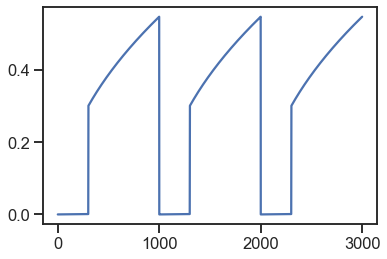

In [84]:
plt.plot(np.array(a._hist)[:, 1])

In [29]:
model.evaluate(valid_data, steps=10)

10/10 [==============================] - 2s 156ms/step - loss: 2.6406 - ECE: 14.0423


[2.6406365633010864, 14.042313]

In [30]:
model.save('test_model.h5')

In [33]:
model = tf.keras.models.load_model(
    'test_model.h5',
    custom_objects={
        'PositionEmbedding': PositionEmbedding,
        'TokenEmbedding': TokenEmbedding,
        'Attention': Attention,
        'Transformer': Transformer,
        'Projection': Projection,        
        'Bias': Bias,
        'gelu': gelu,
        'masked_sparse_categorical_crossentropy': masked_sparse_categorical_crossentropy,
        'ECE': ECE,
    })

# true_labels = layers.Input(shape=(None,), dtype=tf.int32, batch_size=None)
# model.compile(loss=masked_sparse_cross_entropy_loss, target_tensors=true_labels,
#               optimizer=tfa.optimizers.AdamW(weight_decay=0.01, learning_rate=1E-3))

Tensor("metrics_4/ECE/boolean_mask_1/GatherV2:0", shape=(None,), dtype=float32)
Tensor("loss_2/bias_1_loss/boolean_mask_1/GatherV2:0", shape=(None,), dtype=float32)


/home/pstjohn/miniconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [34]:
model.evaluate(valid_data, steps=10)

Tensor("loss/bias_1_loss/boolean_mask_1/GatherV2:0", shape=(None, 22), dtype=float32)
Tensor("metrics/ECE/boolean_mask_1/GatherV2:0", shape=(None, 22), dtype=float32)
10/10 [==============================] - 2s 232ms/step - loss: 2.6753 - ECE: 14.5317


[2.6753330707550047, 14.531654]

In [35]:
model.fit(training_data, steps_per_epoch=100, epochs=3, verbose=1,
          validation_data=valid_data, validation_steps=10)

Train for 100 steps, validate for 10 steps
Epoch 1/3
Tensor("loss/bias_1_loss/boolean_mask_1/GatherV2:0", shape=(None, 22), dtype=float32)


/home/pstjohn/miniconda3/envs/tf2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Tensor("metrics/ECE/boolean_mask_1/GatherV2:0", shape=(None, 22), dtype=float32)
100/100 [==============================] - 6s 61ms/step - loss: 2.6619 - ECE: 14.3414 - val_loss: 2.6444 - val_ECE: 14.1091
Epoch 2/3
100/100 [==============================] - 4s 35ms/step - loss: 2.6664 - ECE: 14.4085 - val_loss: 2.6439 - val_ECE: 14.1070
Epoch 3/3
100/100 [==============================] - 4s 36ms/step - loss: 2.6620 - ECE: 14.3416 - val_loss: 2.6658 - val_ECE: 14.3950


In [ ]:
# eval_data = valid_data.map(sp_encode_tf, num_parallel_calls=tf.data.experimental.AUTOTUNE).padded_batch(60, padded_shapes=([512],))
# eval_encoded = next(iter(eval_data))

In [ ]:
bert_predict = model.predict(encoded_data.take(3), verbose=1)

In [ ]:
bert_predict.shape